In [1]:
import os, sys, glob

import argparse
parser = argparse.ArgumentParser()
# Dataset
parser.add_argument('--set', type=str, default='valid')
# Model/Config
parser.add_argument('--step', type=str, default='050000')
parser.add_argument('--ckpt_selector', type=str, default='ema')
parser.add_argument('--cfg_name', type=str, default=None)
parser.add_argument('--log_dir', type=str, default=None)
# Interpolation
parser.add_argument('--interpolate', nargs='+', default=None)
parser.add_argument('--interpolate_step', type=int, default=15)
parser.add_argument('--interpolate_noise', action='store_true', default=False)
parser.add_argument('--lerp', action='store_true', default=False)
parser.add_argument('--slerp', action='store_true', default=False)
parser.add_argument('--uncond_sampling', action='store_true', default=False)
parser.add_argument('--uncond_sampling_iters', type=int, default=1)
parser.add_argument('--reverse_sampling', action='store_true', default=False)
parser.add_argument('--separate_reverse_sampling', action='store_true', default=False)
# Samples selection
parser.add_argument('--n_subject', type=int, default=-1)
parser.add_argument('--sample_pair_json', type=str, default=None)
parser.add_argument('--sample_pair_mode', type=str, default=None)
parser.add_argument('--src_dst', nargs='+', default=[])
# Pertubation the image condition
parser.add_argument('--perturb_img_cond', action='store_true', default=False)
parser.add_argument('--perturb_mode', type=str, default='zero')
parser.add_argument('--perturb_where', nargs='+', default=[])

# Rendering
parser.add_argument('--render_mode', type=str, default="shape")
parser.add_argument('--rotate_normals', action='store_true', default=False)
# Diffusion
parser.add_argument('--diffusion_steps', type=int, default=1000)
parser.add_argument('--denoised_clamp', type=float, default=None)
# Misc.
parser.add_argument('--seed', type=int, default=23)
parser.add_argument('--gpu_id', type=str, default="0")
parser.add_argument('--save_intermediate', action='store_true', default=False)
parser.add_argument('--postfix', type=str, default='')
parser.add_argument('--ovr_img', type=str, default=None)
parser.add_argument('--ovr_mod', action='store_true', default=False)
parser.add_argument('--norm_img', action='store_true', default=False)
parser.add_argument('--use_global_norm', action='store_true', default=False)
parser.add_argument('--norm_space', type=str, default='rgb')

args = parser.parse_args(args=[])

import os, sys, glob
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
import PIL, cv2
import json
import copy
import time
import torchvision
import pytorch_lightning as pl
sys.path.insert(0, '../../../')
from guided_diffusion.script_util import (
    seed_all,
)

from guided_diffusion.tensor_util import (
    make_deepcopyable,
)

import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs, figsize=(8, 6)):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=figsize)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

from guided_diffusion.dataloader.img_deca_datasets import load_data_img_deca

# Sample utils
sys.path.insert(0, '../../')
from sample_utils import (
    ckpt_utils, 
    params_utils, 
    vis_utils, 
    file_utils, 
    inference_utils, 
    mani_utils,
)
device = 'cuda' if th.cuda.is_available() and th._C._cuda_getDeviceCount() > 0 else 'cpu'

In [2]:
seed_all(47)

################ SETTINGS ################
# args.cfg_name = "Masked_Face_woclip_segface_nonspatial.yaml"
# args.log_dir = "Masked_Face_woclip_segface_nonspatial"
args.cfg_name = "original_dpm_segface.yaml"
args.log_dir = "original_dpm_segface"

args.step = '050000'
args.ckpt_selector = 'ema'
args.set = 'valid'
args.sample_pair_json = './sample_json/ipynb_samples.json'
args.sample_pair_mode = 'pair'

# Load Ckpt
if args.cfg_name is None:
    args.cfg_name = args.log_dir + '.yaml'
ckpt_loader = ckpt_utils.CkptLoader(log_dir=args.log_dir, cfg_name=args.cfg_name)
cfg = ckpt_loader.cfg

print(f"[#] Sampling with diffusion_steps = {args.diffusion_steps}")
cfg.diffusion.diffusion_steps = args.diffusion_steps
model_dict, diffusion = ckpt_loader.load_model(ckpt_selector=args.ckpt_selector, step=args.step)
model_dict = inference_utils.eval_mode(model_dict)

# Load dataset
if args.set == 'itw':
    img_dataset_path = "../../itw_images/aligned/"
    deca_dataset_path = None
elif args.set == 'train' or args.set == 'valid':
    img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
    deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"
else: raise NotImplementedError

loader, dataset, avg_dict = load_data_img_deca(
    data_dir=img_dataset_path,
    deca_dir=deca_dataset_path,
    batch_size=int(1e7),
    image_size=cfg.img_model.image_size,
    deterministic=cfg.train.deterministic,
    augment_mode=cfg.img_model.augment_mode,
    resize_mode=cfg.img_model.resize_mode,
    in_image_UNet=cfg.img_model.in_image,
    params_selector=cfg.param_model.params_selector,
    rmv_params=cfg.param_model.rmv_params,
    set_=args.set,
    cfg=cfg,
    mode='sampling'
)

# DECA Rendering
if np.any(['deca_masked' in n for n in list(filter(None, dataset.condition_image))]):
    mask = params_utils.load_flame_mask()
else: 
    mask=None
deca_obj = params_utils.init_deca(mask=mask)

[#] Model Path : 
#0 : /data/mint/model_logs_mount/v7/original_dpm_segface/
[#] Config Path :  ['/home/mint/guided-diffusion/config/CVPRs/TrainOnSegmentFace/original_dpm_segface.yaml']
Merging with :  Namespace(cfg='/home/mint/guided-diffusion/config/CVPRs/TrainOnSegmentFace/original_dpm_segface.yaml')

[#] Sampling with diffusion_steps = 1000
[#] Available ckpt :  ['_000000.pt', '_010000.pt', '_020000.pt', '_030000.pt', '_040000.pt', '_050000.pt', '_060000.pt', '_070000.pt', '_080000.pt']
[#] Loading.../data/mint/model_logs_mount/v7/original_dpm_segface//ImgCond_ema_0.9999_050000.pt


Loading deca params...: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


[#] Bounding the input of UNet to +-1.0
[#] Parameters Conditioning
Params keys order :  []
Remove keys :  []
Input Image :  ['faceseg_head']
Image condition :  ['raw']
DPM Image condition :  [None]
creating the FLAME Decoder


In [3]:
data_size = dataset.__len__()
img_path = file_utils._list_image_files_recursively(f"{img_dataset_path}/{args.set}")


denoised_fn = None
pl_sampling = inference_utils.PLSampling(model_dict=model_dict, 
                                            diffusion=diffusion, 
                                            reverse_fn=diffusion.ddim_reverse_sample_loop, 
                                            forward_fn=diffusion.ddim_sample_loop,
                                            denoised_fn=denoised_fn,
                                            cfg=cfg,
                                            args=args)

def rgb_to_gray(img):
    out = (img[:, 0:1] * 0.2989) + (img[:, 1:2] * 0.5870) + (img[:, 2:3] * 0.1140)
    return out

In [4]:
def inversion(dat, norm_img, cond, norm_space='gray', sdedit=None):
    '''
    :param dat: images in B x C x H x W
    '''
    cond['use_cond_xt_fn'] = False
    cond['dpm_cond_img'] = None 
    
    if norm_img:
        print(f"[#] Normalize image in {norm_space}...")
       
        gray = rgb_to_gray(dat)
        sd, mu = th.std_mean(gray, dim=(1, 2, 3), keepdims=True)
        # print(sd, mu, gray.shape, dat.shape)
        # print(sd.shape, mu.shape, gray.shape, dat.shape)
        mu_d, sd_d = 114.49997340551313, 58.050383371049826
        mu_d = (mu_d / 127.5) - 1
        sd_d = (sd_d / 127.5)
        
        img = (dat - mu) / sd
        img = (img * sd_d) + mu_d
        
        #img = dat + 0.2
        img = th.clip(img, -1, 1)
        #show([(img[0] + 1) * 0.5, (dat[0] + 1) * 0.5])
        #return None
    else:
        img = dat

    # Reverse   
    reverse_ddim_sample = pl_sampling.reverse_proc(x=img, model_kwargs=cond, store_intermediate=False)
    noise_map = reverse_ddim_sample['final_output']['sample']
    # Forward   
    sample_ddim = pl_sampling.forward_proc(noise=noise_map, model_kwargs=cond, store_intermediate=False, sdedit=sdedit)
    
    out = sample_ddim['final_output']['sample']
    if norm_img:
        print("[#] DeNormalize image...")

        out = (out - mu_d) / sd_d
        out = (out * sd) + mu
        
    sample_frames = (out + 1) * 0.5
    
    return sample_frames   

def reverse(dat, norm_img, cond, norm_space='gray'):
    '''
    :param dat: images in 1 x C x H x W
    '''
    
    assert dat.shape[0] == 1
    if norm_img:
        print(f"[#] Normalize image in {norm_space}...")
       
        gray = rgb_to_gray(dat)
        sd, mu = th.std_mean(gray)
        mu_d, sd_d = 114.49997340551313, 58.050383371049826
        mu_d = (mu_d / 127.5) - 1
        sd_d = (sd_d / 127.5)
        
        img = (dat - mu) / sd
        img = (img * sd_d) + mu_d
        
        #img = dat + 0.2
        img = th.clip(img, -1, 1)
        #show([(img[0] + 1) * 0.5, (dat[0] + 1) * 0.5])
        #return None
        nf = {'mu':mu, 'sd':sd, 'mu_d':mu_d, 'sd_d':sd_d}
    else:
        img = dat
        nf = {}

    # Reverse   
    reverse_ddim_sample = pl_sampling.reverse_proc(x=img, model_kwargs=cond, store_intermediate=False)
    noise_map = reverse_ddim_sample['final_output']['sample']
        
    return noise_map, nf 
    
def forward(noise_map, cond, norm_img, nf):
    
    # Forward   
    sample_ddim = pl_sampling.forward_proc(noise=noise_map, model_kwargs=cond, store_intermediate=False)
    
    out = sample_ddim['final_output']['sample']
    if norm_img:
        print("[#] DeNormalize image...")
        out = (out - nf['mu_d']) / nf['sd_d']
        out = (out * nf['sd']) + nf['mu']
        
    sample_frames = (out + 1) * 0.5
    
    return sample_frames   

# Manipulate the condition

In [5]:
def make_condition(cond, src_idx, dst_idx, n_step=2, itp_func=None):
    condition_img = list(filter(None, dataset.condition_image))
    misc = {'condition_img':condition_img,
            'src_idx':src_idx,
            'dst_idx':dst_idx,
            'n_step':n_step,
            'avg_dict':avg_dict,
            'dataset':dataset,
            'args':args,
            'itp_func':itp_func,
            'img_size':cfg.img_model.image_size,
            'deca_obj':deca_obj
            }  
    if itp_func is not None:
        cond['use_render_itp'] = False 
    else:
        cond['use_render_itp'] = True
        
    cond, clip_ren = inference_utils.build_condition_image(cond=cond, misc=misc)
    cond = inference_utils.prepare_cond_sampling(cond=cond, cfg=cfg, use_render_itp=True)
    

    if 'render_face' in args.interpolate:
        interp_set = args.interpolate.copy()
        interp_set.remove('render_face')
        
    # Interpolate non-spatial
    interp_cond = mani_utils.iter_interp_cond(cond, interp_set=interp_set, src_idx=src_idx, dst_idx=dst_idx, n_step=n_step, interp_fn=itp_func)
    cond.update(interp_cond)
        
    # Repeated non-spatial
    repeated_cond = mani_utils.repeat_cond_params(cond, base_idx=src_idx, n=n_step, key=mani_utils.without(cfg.param_model.params_selector, args.interpolate + ['light', 'img_latent']))
    cond.update(repeated_cond)

    # Finalize the cond_params
    cond = mani_utils.create_cond_params(cond=cond, key=mani_utils.without(cfg.param_model.params_selector, cfg.param_model.rmv_params))
    if cfg.img_cond_model.override_cond != '':
        to_tensor_key = ['cond_params'] + cfg.param_model.params_selector + [cfg.img_cond_model.override_cond]
    else:    
        to_tensor_key = ['cond_params'] + cfg.param_model.params_selector
    cond = inference_utils.to_tensor(cond, key=to_tensor_key, device=ckpt_loader.device)
    
    return cond
    

# Background

In [6]:
def face_part(mask, part='faceseg_head'):
    mask = np.array(mask)
    bg = (mask == 0)
    skin = (mask == 1)
    l_brow = (mask == 2)
    r_brow = (mask == 3)
    l_eye = (mask == 4)
    r_eye = (mask == 5)
    eye_g = (mask == 6)
    l_ear = (mask == 7)
    r_ear = (mask == 8)
    ear_r = (mask == 9)
    nose = (mask == 10)
    mouth = (mask == 11)
    u_lip = (mask == 12)
    l_lip = (mask == 13)
    neck = (mask == 14)
    neck_l = (mask == 15)
    cloth = (mask == 16)
    hair = (mask == 17)
    hat = (mask == 18)
    face = np.logical_or.reduce((skin, l_brow, r_brow, l_eye, r_eye, eye_g, l_ear, r_ear, ear_r, nose, mouth, u_lip, l_lip))
    if part == 'faceseg_head':
        seg_m = (face | neck | hair)
    return th.tensor(seg_m)

def replace_bg(image_name, rpl=None, vis=False):
    mask = PIL.Image.open(f"/data/mint/DPM_Dataset/ffhq_256_with_anno/face_segment/valid/anno/anno_{image_name}.png")
    img = PIL.Image.open(f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/valid/{image_name}.jpg")

    # Load to [0, 1] image
    mask = face_part(mask)
    img = torchvision.transforms.ToTensor()(img) * 2 - 1
    rpl_mode = list(rpl.keys())[0]
    rpl_val = list(rpl.values())[0]
    
    if rpl_mode == 'constant':
        print(f"[#] Replace bg with {rpl_val}")
        rpl_bg = (th.randn_like(img) * 0 + rpl_val['val'])
    elif rpl_mode == 'balance_rgb':
        m_f, m_bg = mask!=0, mask==0
        assert (m_f + m_bg) == 256**2
        n_f, n_bg, n_pixel = th.sum(m_f)*3, th.sum(m_bg)*3, (256**2)*3
        mu_f =  th.sum(m_f * img) / n_f
        val = ((0 * n_pixel) - (n_f * mu_f)) / (n_bg)
        val = th.clip(val, -1, 1)
        rpl_bg = (th.randn_like(img) * 0 + val)
        print(f"[#] Replace bg with {val}")
    elif rpl_mode == 'mu_sd':
        rpl_bg = (th.randn_like(img) * rpl_val['sd'] + rpl_val['mu'])
    elif rpl_mode == 'image':
        bg_img = PIL.Image.open(f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/valid/{rpl_val}")
        bg_img = torchvision.transforms.ToTensor()(bg_img) * 2 - 1
        rpl_bg = bg_img
    elif rpl_mode == 'balance_Ndist':
        mu_d = 114.49997340551313 / 127.5 - 1
        sd = rpl_val['sd']
        m_f, m_bg = mask!=0, mask==0
        n_f, n_bg, n_pixel = th.sum(m_f)*3, th.sum(m_bg)*3, (256**2)*3
        mu_f =  th.sum(m_f * img) / n_f
        val = ((mu_d * n_pixel) - (n_f * mu_f)) / (n_bg)
        print(f"[#] Replace bg with Ndist({val}, {rpl_val['sd']}), clip={rpl_val['clip']}")
        rpl_bg = (th.normal(mean=val, std=sd, size=img.shape))
        if rpl_val['clip']:
            rpl_bg = th.clip(rpl_bg, -1, 1)
    else: raise NotImplementedError
    
    mod_img = img * (mask != 0) + rpl_bg * (mask == 0)
    mod_img = torchvision.transforms.Resize((128, 128))(mod_img)
    bg_img = img * (mask == 0) + rpl_bg * (mask != 0)
    bg_img = torchvision.transforms.Resize((128, 128))(bg_img)
    mask = torchvision.transforms.Resize((128, 128), interpolation=PIL.Image.NEAREST)(mask[None])
    img = torchvision.transforms.Resize((128, 128))(img)
    
    print('Mean : ', th.mean(mod_img))
    
    if vis:
        show(torchvision.utils.make_grid((mod_img + 1) * 0.5), figsize=(4, 8))
    return img, mod_img, bg_img, mask 


# Inversion 

/home/mint/guided-diffusion/sample_scripts/py/relighting_sample_id/sampling/../../../sample_utils/inference_utils.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cond[f"{cond_img_name}"] = th.tensor(bg_tmp)
Global seed set to 47


[#] Repeating cond :  []
[#] Condition build from parameters in  []
[#] Replace bg with Ndist(1.2227989435195923, 0.1), clip=True
Mean :  tensor(-0.15687)
[#] Replace bg with Ndist(1.2227989435195923, 0.5), clip=True
Mean :  tensor(-0.18346)
[#] Replace bg with Ndist(1.2227989435195923, 0.45529712447882215), clip=True
Mean :  tensor(-0.17935)
[#] Without normalize


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

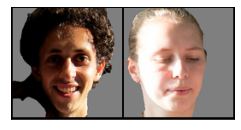

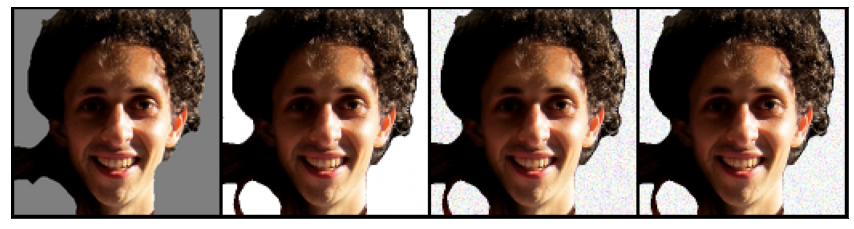

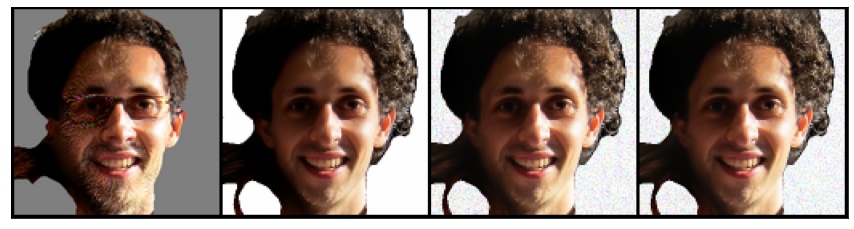

In [9]:
from pytorch_lightning import seed_everything


all_img_idx, all_img_name, args.n_subject = mani_utils.get_samples_list(args.sample_pair_json, 
                                                                        args.sample_pair_mode, 
                                                                        args.src_dst, img_path, 
                                                                        args.n_subject)

idx = 0 # Sample index related to json order
img_idx = all_img_idx[idx]
img_name = all_img_name[idx]

dat = th.utils.data.Subset(dataset, indices=img_idx)
subset_loader = th.utils.data.DataLoader(dat, batch_size=2,
                                    shuffle=False, num_workers=24)
                            
# Load image & condition                            
dat, model_kwargs = list(iter(subset_loader))[0]
show(torchvision.utils.make_grid((dat + 1) * 0.5), figsize=(4, 8))
# Rendering
args.interpolate = ['render_face']
cond = copy.deepcopy(model_kwargs)
cond = make_condition(cond=cond, 
                      src_idx=0, dst_idx=1, 
                      n_step=3, itp_func=mani_utils.slerp)
cond['use_cond_xt_fn'] = False
cond['dpm_cond_img'] = None 

# Forward to Encoder
if cfg.img_cond_model.apply:
    cond['cond_img'] = th.repeat_interleave(cond['cond_img'][0:1, ...], repeats=1, dim=0)
    cond = pl_sampling.forward_cond_network(model_kwargs=cond)
    
d_tmp = []
# for i in ['60182.jpg', '60008.jpg', '68782.jpg', -1.0, -0.5, 0.0, 0.5, 1.0]:
seed_everything(47)
# rpl_bg = [{'balance_Ndist':{'sd':0.1, 'clip':False}}, 
            # {'balance_Ndist':{'sd':0.1, 'clip':True}}, 
            # {'balance_Ndist':{'sd':0.5, 'clip':False}}, 
            # {'balance_Ndist':{'sd':0.5, 'clip':True}}, 
            # {'balance_Ndist':{'sd':1, 'clip':False}}, 
            # {'balance_Ndist':{'sd':1, 'clip':True}}, 
            # {'balance_Ndist':{'sd':58.050383371049826/127.5, 'clip':False}},
            # {'balance_Ndist':{'sd':58.050383371049826/127.5, 'clip':True}}]
rpl_bg = [None, {'balance_Ndist':{'sd':0.1, 'clip':True}}, {'balance_Ndist':{'sd':0.5, 'clip':True}}, {'balance_Ndist':{'sd':58.050383371049826/127.5, 'clip':True}}]
for i in rpl_bg:
    if i is not None:
        d, mod_img, bg, m = replace_bg(image_name=model_kwargs['image_name'][0].split('.')[0], rpl=i)
        dat = mod_img[None][0:1, ...].cuda()
    else:
        dat = dat[0:1, ...].cuda()
    d_tmp.append(dat.cuda())
    
dat = th.cat(d_tmp, dim=0)
show(torchvision.utils.make_grid((dat + 1) * 0.5), figsize=(15, 15))

# # Reverse & Forward
# print("[#] With normalize")
# out_norm = inversion(dat=dat.clone(), norm_img=True, cond=make_deepcopyable(cond, keys=list(cond.keys())))
# # show(torchvision.utils.make_grid(out_norm), figsize=(15, 15))
# show(torchvision.utils.make_grid(th.clip(out_norm, 0, 1)), figsize=(15, 15))

print("[#] Without normalize")
out = inversion(dat=dat.clone(), norm_img=False, cond=make_deepcopyable(cond, keys=list(cond.keys())))
# show(torchvision.utils.make_grid(out), figsize=(15, 15))
show(torchvision.utils.make_grid(th.clip(out, 0, 1)), figsize=(15, 15))

